In [1]:
pip install scikit-learn==0.23.2

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import numpy as np
#import lightgbm
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB

# **Database Connection**

In [3]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [4]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-11-24 04:10:54--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.3’

postgresql-42.2.16. 100%[===================>] 979.38K  1.18MB/s    in 0.8s    

2021-11-24 04:10:56 (1.18 MB/s) - ‘postgresql-42.2.16.jar.3’ saved [1002883/1002883]



In [5]:
pip install Config

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("M16-Amazon-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

# Configure settings for RDS
jdbc_url="jdbc:postgresql://datavizm16.cyekg13tmsth.us-east-2.rds.amazonaws.com:5432/postgres"

In [7]:
config = {"user":"postgres", 
          "password": config, 
          "driver":"org.postgresql.Driver"}
print(config)

{'user': 'postgres', 'password': 'asdf1234', 'driver': 'org.postgresql.Driver'}


In [8]:
df = spark.read.jdbc(url=jdbc_url, table='customer_churn', properties=config)
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerid|gender|seniorcitizen|partner|dependents|tenure|phoneservice|   multiplelines|internetservice|     onlinesecurity|       onlinebackup|   deviceprotection|        techsupport|        streamingtv|    streamingmovies|      contract|paperlessbilling|       paymentmethod|monthlycharges|totalcharges|churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

# **Preprocessing**

In [9]:
# Create dataframe
df = df.toPandas()
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
# Set 'custormerid' column as the index
df.set_index('customerid', inplace=True)
df

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
customerid,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


In [11]:
# Drop NaNs
df.dropna(inplace = True)

In [12]:
# Check for null value
df.isnull().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [13]:
df

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
customerid,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


In [14]:
# Check data type
df.dtypes

gender               object
seniorcitizen         int32
partner              object
dependents           object
tenure                int32
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                object
dtype: object

# **Encoding, scaling and splitting the data**

In [15]:
# Generate our categorical variable lists
cat = df.dtypes[df.dtypes == 'object'].index.tolist()
cat

['gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'churn']

In [16]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat)
encode_df.head()

,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phoneservice_No,phoneservice_Yes,multiplelines_No,multiplelines_No phone service,multiplelines_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,onlinesecurity_No,onlinesecurity_No internet service,onlinesecurity_Yes,onlinebackup_No,onlinebackup_No internet service,onlinebackup_Yes,deviceprotection_No,deviceprotection_No internet service,deviceprotection_Yes,techsupport_No,techsupport_No internet service,techsupport_Yes,streamingtv_No,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No,streamingmovies_No internet service,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,churn_No,churn_Yes
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [17]:
# Merge one-hot encoded features and drop the originals
df.reset_index(drop=True, inplace=True)
df_encoded = df.merge(encode_df, left_index=True, right_index=True)
df_encoded = df_encoded.drop(cat, 1)
df_encoded.head()

,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phoneservice_No,phoneservice_Yes,multiplelines_No,multiplelines_No phone service,multiplelines_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,onlinesecurity_No,onlinesecurity_No internet service,onlinesecurity_Yes,onlinebackup_No,onlinebackup_No internet service,onlinebackup_Yes,deviceprotection_No,deviceprotection_No internet service,deviceprotection_Yes,techsupport_No,techsupport_No internet service,techsupport_Yes,streamingtv_No,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No,streamingmovies_No internet service,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,churn_No,churn_Yes
0,0,1,29.85,29.85,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,34,56.95,1889.50,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0,2,53.85,108.15,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,45,42.30,1840.75,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,2,70.70,151.65,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [50]:
# Split our preprocessed data into out features and target arrays
y = df_encoded["churn_Yes"].values
X = df_encoded.drop(['churn_Yes','churn_No'],1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [20]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# **Pycaret**

In [21]:
pip install pycaret

In [22]:
from pycaret.utils import enable_colab 
enable_colab()

Colab mode enabled.


In [26]:
# init setup
from pycaret.classification import *
s = setup(df, target = 'churn')

,Description,Value
0,session_id,2988
1,Target,churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7032, 20)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,15
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
# compare all models
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8060,0.8491,0.5496,0.6660,0.6012,0.4747,0.4792,0.275
gbc,Gradient Boosting Classifier,0.8033,0.8488,0.5419,0.6613,0.5945,0.4666,0.4713,0.674
lr,Logistic Regression,0.8062,0.8434,0.5541,0.6643,0.6031,0.4765,0.4806,0.111
qda,Quadratic Discriminant Analysis,0.7001,0.8378,0.8347,0.4658,0.5977,0.3882,0.4304,0.030
lda,Linear Discriminant Analysis,0.8029,0.8375,0.5633,0.6506,0.6032,0.4731,0.4757,0.040
lightgbm,Light Gradient Boosting Machine,0.7989,0.8349,0.5405,0.6490,0.5887,0.4573,0.4613,0.123
nb,Naive Bayes,0.7471,0.8302,0.7737,0.5173,0.6199,0.4414,0.4617,0.023
rf,Random Forest Classifier,0.7958,0.8230,0.5107,0.6491,0.5709,0.4396,0.4455,0.769
et,Extra Trees Classifier,0.7712,0.7915,0.4695,0.5902,0.5220,0.3744,0.3792,0.766
knn,K Neighbors Classifier,0.7670,0.7543,0.4497,0.5827,0.5064,0.3575,0.3633,0.140


In [33]:
# print best_model parameters
print(best_model)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=2988)


In [34]:
# tune best model
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8174,0.8564,0.5227,0.7188,0.6053,0.4904,0.5009
1,0.8114,0.8362,0.5758,0.6726,0.6204,0.4959,0.4986
2,0.8191,0.8691,0.5573,0.7019,0.6213,0.5045,0.5103
3,0.8069,0.8610,0.5573,0.6636,0.6058,0.4792,0.4824
4,0.8049,0.8607,0.5649,0.6549,0.6066,0.4778,0.4801
5,0.8110,0.8079,0.5573,0.6759,0.6109,0.4876,0.4915
6,0.8272,0.8540,0.6336,0.6917,0.6614,0.5457,0.5466
7,0.7866,0.8462,0.5649,0.6066,0.5850,0.4416,0.4421
8,0.7988,0.8586,0.5115,0.6569,0.5751,0.4459,0.4519
9,0.7947,0.8459,0.4733,0.6596,0.5511,0.4227,0.4325


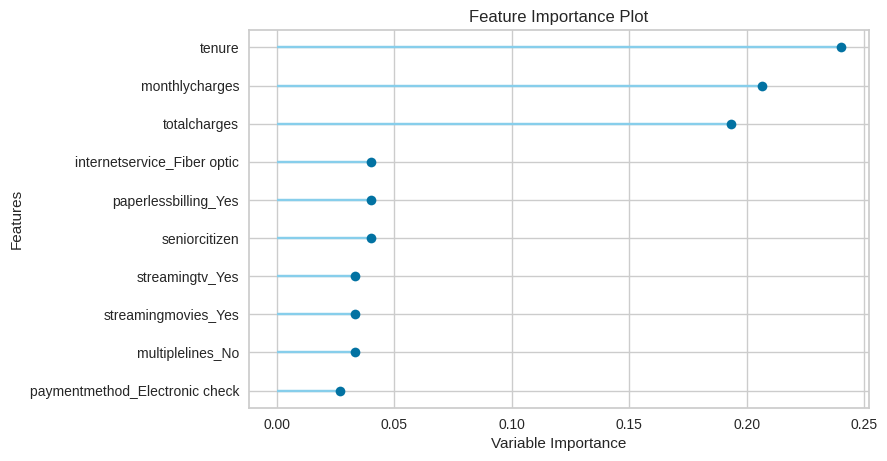

In [35]:
# Feature Importance Plot
plot_model(tuned_best_model, plot = 'feature')

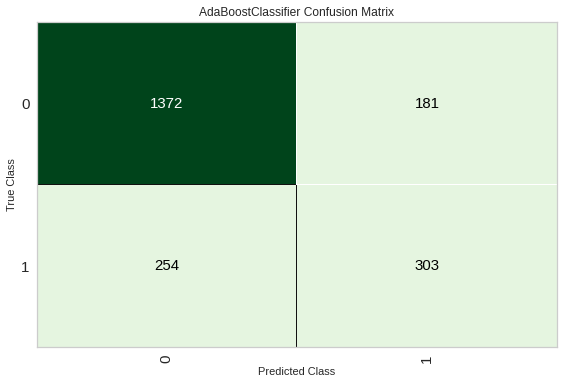

In [36]:
# Confusion Matrix
plot_model(tuned_best_model, plot = 'confusion_matrix')

# **Custom Function in Pycaret**

In [37]:
# create a custom function
# Example using 1000 and 3000
def calculate_profit(y, y_pred):
    true_positive = np.where((y_pred==1) & (y==1), (3000-1000), 0)
    false_positive = np.where((y_pred==1) & (y==0), -1000, 0)
    return np.sum([true_positive,false_positive])
# add metric to PyCaret
add_metric('profit3', 'Profit3', calculate_profit)

Name                                                       Profit3
Display Name                                               Profit3
Score Function       <function calculate_profit at 0x7f4183af8b90>
Scorer                               make_scorer(calculate_profit)
Target                                                        pred
Args                                                            {}
Greater is Better                                             True
Multiclass                                                    True
Custom                                                        True
Name: profit3, dtype: object

In [38]:
# Now let’s run compare_models and see the magic.
best_model = compare_models(sort='Profit3')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit3,TT (Sec)
lr,Logistic Regression,0.8062,0.8434,0.5541,0.6643,0.6031,0.4765,0.4806,108500.0,0.113
nb,Naive Bayes,0.7471,0.8302,0.7737,0.5173,0.6199,0.4414,0.4617,108200.0,0.027
lda,Linear Discriminant Analysis,0.8029,0.8375,0.5633,0.6506,0.6032,0.4731,0.4757,108100.0,0.043
ada,Ada Boost Classifier,0.8060,0.8491,0.5496,0.6660,0.6012,0.4747,0.4792,107800.0,0.283
gbc,Gradient Boosting Classifier,0.8033,0.8488,0.5419,0.6613,0.5945,0.4666,0.4713,105500.0,0.697
ridge,Ridge Classifier,0.8062,0.0000,0.5274,0.6755,0.5914,0.4671,0.4738,105000.0,0.023
lightgbm,Light Gradient Boosting Machine,0.7989,0.8349,0.5405,0.6490,0.5887,0.4573,0.4613,103100.0,0.131
rf,Random Forest Classifier,0.7958,0.8230,0.5107,0.6491,0.5709,0.4396,0.4455,97700.0,0.776
qda,Quadratic Discriminant Analysis,0.7001,0.8378,0.8347,0.4658,0.5977,0.3882,0.4304,93100.0,0.031
et,Extra Trees Classifier,0.7712,0.7915,0.4695,0.5902,0.5220,0.3744,0.3792,80200.0,0.774


# **RandomForestClassifier**

In [39]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.774


In [40]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[1144,  136],
       [ 261,  217]])

In [41]:
# Print the imbalanced classification report - BalancedRandomForestClassifier
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.81      0.89      0.45      0.85      0.64      0.42      1280
        1.0       0.61      0.45      0.89      0.52      0.64      0.39       478

avg / total       0.76      0.77      0.57      0.76      0.64      0.41      1758



In [42]:
importance = rf_model.feature_importances_
importance

array([0.02067051, 0.13928471, 0.13763928, 0.15903633, 0.01785483,
       0.0171931 , 0.01506146, 0.01409735, 0.01196053, 0.01224225,
       0.00262136, 0.00301018, 0.01378002, 0.00280764, 0.01323078,
       0.00998185, 0.02576258, 0.00295732, 0.03060409, 0.00343643,
       0.01263096, 0.0187366 , 0.00084075, 0.01163992, 0.01507063,
       0.0023874 , 0.01156285, 0.03058461, 0.00227007, 0.01078571,
       0.01063173, 0.00466309, 0.01131847, 0.01007152, 0.00227433,
       0.01101649, 0.05544147, 0.01035753, 0.01980494, 0.01496353,
       0.01602161, 0.01206085, 0.01287537, 0.02742917, 0.0113278 ])

In [51]:
# List features with more impact 

important_features = pd.Series(data=rf_model.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features.head(15)

totalcharges                      0.159036
tenure                            0.139285
monthlycharges                    0.137639
contract_Month-to-month           0.055441
onlinesecurity_No                 0.030604
techsupport_No                    0.030585
paymentmethod_Electronic check    0.027429
internetservice_Fiber optic       0.025763
seniorcitizen                     0.020671
contract_Two year                 0.019805
onlinebackup_No                   0.018737
gender_Female                     0.017855
gender_Male                       0.017193
paperlessbilling_Yes              0.016022
deviceprotection_No               0.015071
dtype: float64

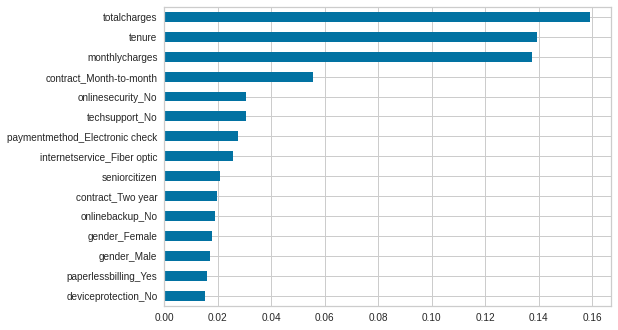

In [52]:
import matplotlib.pyplot as plt

plt.figure();
importance_df = important_features.head(15)
importance_df.sort_values(ascending=True,inplace=True)
importance_df.plot.barh();

# **Logistic Regression**

In [53]:
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model
log_classifier = LogisticRegression(solver="lbfgs",max_iter=200)

# Train the model
log_classifier.fit(X_train_scaled,y_train)

# Evaluate the model
y_pred = log_classifier.predict(X_test_scaled)
print(f" Logistic regression model accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Logistic regression model accuracy: 0.790


In [54]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,1135,145
Actual 1,224,254


In [55]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86      1280
         1.0       0.64      0.53      0.58       478

    accuracy                           0.79      1758
   macro avg       0.74      0.71      0.72      1758
weighted avg       0.78      0.79      0.78      1758



# **Deep Learning Model**

In [56]:
# Define the basic neural network model
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=45))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
165/165 [==============================] - 1s 2ms/step - loss: 0.6105 - accuracy: 0.7363
Epoch 2/50
165/165 [==============================] - 0s 1ms/step - loss: 0.5459 - accuracy: 0.7363
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4947 - accuracy: 0.7363
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4748 - accuracy: 0.7363
Epoch 5/50
165/165 [==============================] - 0s 1ms/step - loss: 0.4665 - accuracy: 0.7363
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4613 - accuracy: 0.7363
Epoch 7/50
165/165 [==============================] - 0s 1ms/step - loss: 0.4573 - accuracy: 0.7363
Epoch 8/50
165/165 [==============================] - 0s 1ms/step - loss: 0.4540 - accuracy: 0.7363
Epoch 9/50
165/165 [==============================] - 0s 1ms/step - loss: 0.4510 - accuracy: 0.7363
Epoch 10/50
165/165 [==============================] - 0s 1ms/step - loss: 0.4484 - accuracy: 0.7363

In [57]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

55/55 - 0s - loss: 0.4545 - accuracy: 0.7878 - 203ms/epoch - 4ms/step
Loss: 0.4545261561870575, Accuracy: 0.7878270745277405


In [58]:
# Adding some settings to the basic neural model - attempt to improve accuracy

# Define the model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=50, input_dim=45, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=20, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=10, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                2300      
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,541
Trainable params: 3,541
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="SGD", metrics=["accuracy"])

fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
165/165 [==============================] - 1s 2ms/step - loss: 0.5367 - accuracy: 0.7372
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.7564
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4493 - accuracy: 0.7791
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.7922
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4301 - accuracy: 0.7964
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4254 - accuracy: 0.7996
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.8007
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4189 - accuracy: 0.8024
Epoch 9/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4165 - accuracy: 0.8041
Epoch 10/50
165/165 [==============================] - 0s 2ms/step - loss: 0.4140 - accuracy: 0.8032

In [60]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

55/55 - 0s - loss: 0.4627 - accuracy: 0.7765 - 196ms/epoch - 4ms/step
Loss: 0.4626879096031189, Accuracy: 0.776450514793396


# **Naive Bayes**

In [61]:
# Training the Naive Bayes model on the training set
classifier = GaussianNB()
classifier.fit(X_train_scaled, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [62]:
y_pred = classifier.predict(X_test_scaled)
print(f" Naive Bayes model accuracy: {accuracy_score(y_test, y_pred):.3f}")

 Naive Bayes model accuracy: 0.680


In [63]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.90      0.63      0.74      1280
         1.0       0.45      0.82      0.58       478

    accuracy                           0.68      1758
   macro avg       0.68      0.72      0.66      1758
weighted avg       0.78      0.68      0.70      1758



In [64]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,806,474
Actual 1,88,390


# **Naive Bayes - hyperparameter tuning**
Using RepeatedStratifiedKFold and GridSearchCV 
(https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/)

In [65]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [66]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5,  n_repeats=10, random_state=999)

In [67]:
from sklearn.preprocessing import PowerTransformer

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=GaussianNB(), param_grid=params_NB, cv=cv_method, verbose=1, scoring='recall')

Data_transformed = PowerTransformer().fit_transform(X_test_scaled)

gs_NB.fit(Data_transformed, y_test);

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   18.3s finished


In [68]:
# predict the target on the test dataset
predict_test = gs_NB.predict(Data_transformed)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.646188850967008


In [69]:
# Calculating the confusion matrix
cm3 = confusion_matrix(y_test, predict_test)

# Create a DataFrame from the confusion matrix.
cm_df3 = pd.DataFrame(
    cm3, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df3

,Predicted 0,Predicted 1
Actual 0,726,554
Actual 1,68,410


In [70]:
report = classification_report(y_test, predict_test)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.57      0.70      1280
         1.0       0.43      0.86      0.57       478

    accuracy                           0.65      1758
   macro avg       0.67      0.71      0.63      1758
weighted avg       0.78      0.65      0.66      1758



# Tuning - explained
Data may not have a Gaussian distribution and instead may have a Gaussian-like distribution (e.g. nearly Gaussian but with outliers or a skew) or a totally different distribution (e.g. exponential). As such, we may be able to achieve better performance on a wide range of machine learning algorithms by transforming input and/or output variables to have a Gaussian or more-Gaussian distribution. Some algorithms like linear regression and logistic regression explicitly assume the real-valued variables have a Gaussian distribution.

PowerTransformer() transforms our already scaled data to have a Gaussian distribution.

Power transforms refer to a class of techniques that use a power function (like a logarithm or exponent) to make the probability distribution of a variable Gaussian or more-Gaussian like.These power transforms are available in the scikit-learn Python machine learning library via the PowerTransformer class.

The class takes an argument named “method” that can be set to ‘yeo-johnson‘ or ‘box-cox‘ for the preferred method. It will also standardize the data automatically after the transform, meaning each variable will have a zero mean and unit variance. This can be turned off by setting the “standardize” argument to False.

GridSearchCV - the only parameter we can experiment with in Naive Bayes models is 'var_smoothing'. We are asking GridSearch to find the parameter that retuns the best recall result.